### CTD Transect Report, Lake Zug, 16.12.2025

In [1]:
# imports
import os
from glob import glob
import json
import ewgreaders as ewg
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings; warnings.filterwarnings('ignore')
#%matplotlib qt
%matplotlib inline

In [2]:
def locate_files(root, data_dir, ext):
    dpath = os.path.join(root, data_dir)
    md_files = glob(os.path.join(dpath, '*.meta'))

    profiles = []
    for mdf in md_files:
        fpath, _ = os.path.splitext(mdf)
        profiles.append(f'{fpath}.{ext}')

    return md_files, profiles


def parse_profiles_sea_and_sun(md_files, profiles, bathy):
    data = {}
    for i, (md_file, profile) in tqdm(enumerate(zip(md_files, profiles))):
        with open(md_file, 'r') as f:
            md = json.load(f)
        #i = int(md['profile']['Profile name'][1:]) - 1
        xsc = int(md['profile']['X Coordinate (CH1903)']) + int(2e6)
        ysc = int(md['profile']['Y Coordinate (CH1903)']) + int(1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        with open(profile, encoding='latin1', errors='ignore') as f:
            lines = f.readlines()

        for l in range(len(lines)):
            if "Lines :" in lines[l]:
                break

        columns = lines[l + 2].replace(";", "").split()[1:]
        df = pd.read_csv(profile, sep='\s+', header=None, skiprows=l+5, names=columns, engine='python', encoding='cp1252')

        # select downcast
        bottom_idx = np.argmax(df['Press'])
        df = df[:bottom_idx]

        # remove air
        df = df[df['Press'] > 1]

        data[i] = {
            'loc': md['profile']['Profile name'], 
            'name': os.path.basename(profile),
            'press': df['Press'].values, 
            'temp': df['Temp'].values,
            'd_oxygen_conc': df['DO_mg'].values * (1000/32),
            'total_depth': total_depth
        }

    return data


def plot_profiles(data, dp, var, color):
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(25, 5), sharex=True, sharey=True)

    for i, dat in data.items():
        ax[i].plot(dat[var], dat[dp], c=color)
        ax[i].set_title(dat['name'])

        if dp == 'depth':
            ax[i].axhline(dat['total_depth'], color='gray', linestyle='--')
        
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    if dp == 'depth':
        ax[0].set_ylabel('Depth (m)')
    elif dp == 'press':
        ax[0].set_ylabel('Pressure (dbar)')

    if var == 'temp':
        fig.supxlabel('Temperature (°C)')
    elif var == 'd_oxygen_conc':
        fig.supxlabel('Dissolved Oxygen Concentration (umol/L)')

    ax[0].invert_yaxis()

    plt.tight_layout()
    plt.show()

In [6]:
# Lake Zug bathymetry
bathy = xr.open_dataset('../../../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [7]:
root = 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/CTD/'
data_dir = '20251216/L0'

In [8]:
md_files, profiles = locate_files(root, data_dir, ext='TOB')

In [9]:
data = parse_profiles_sea_and_sun(md_files, profiles, bathy)

0it [00:00, ?it/s]

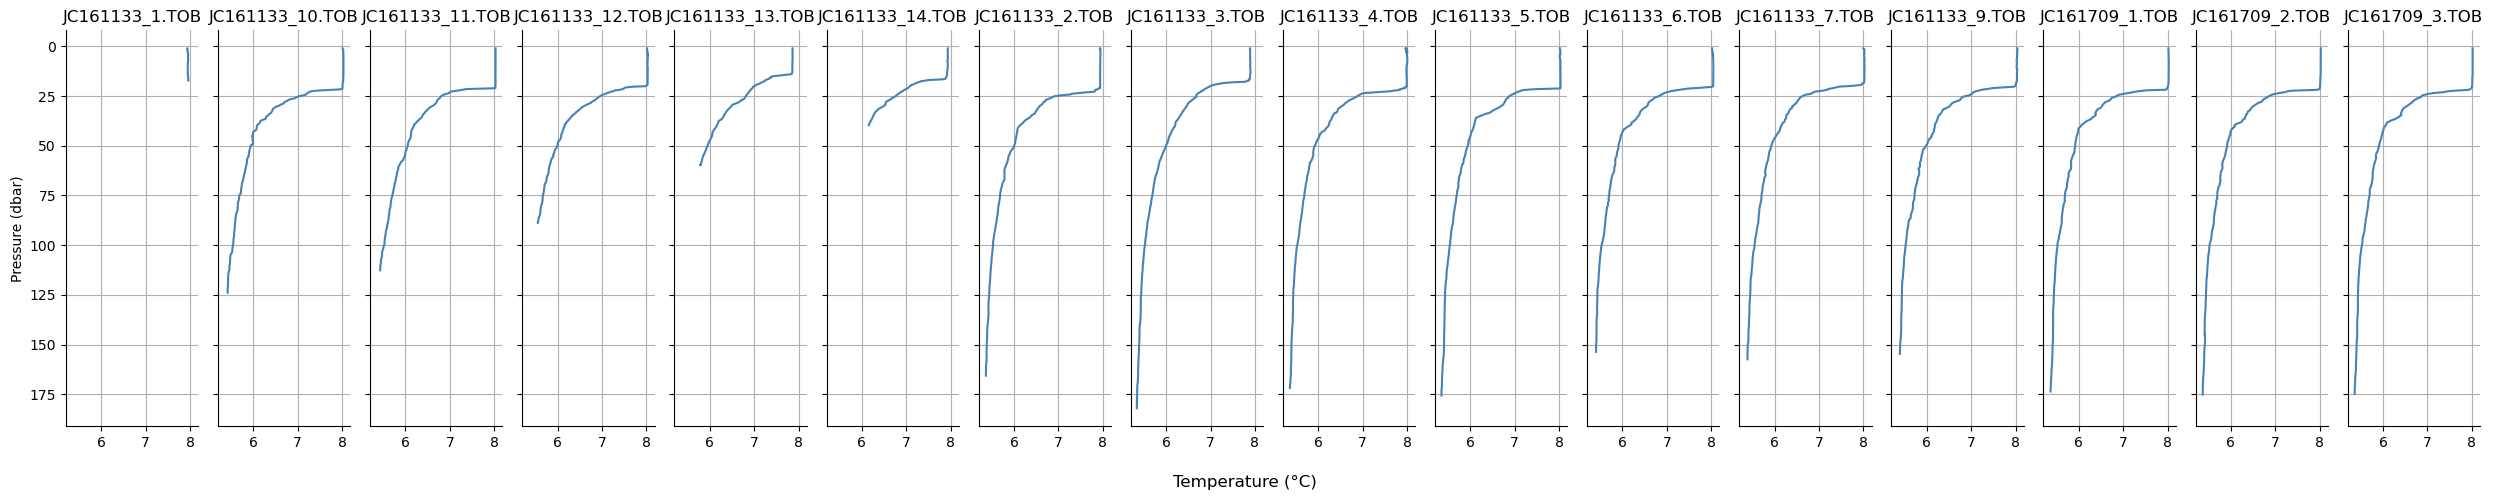

In [13]:
plot_profiles(data, 'press', 'temp', 'steelblue')

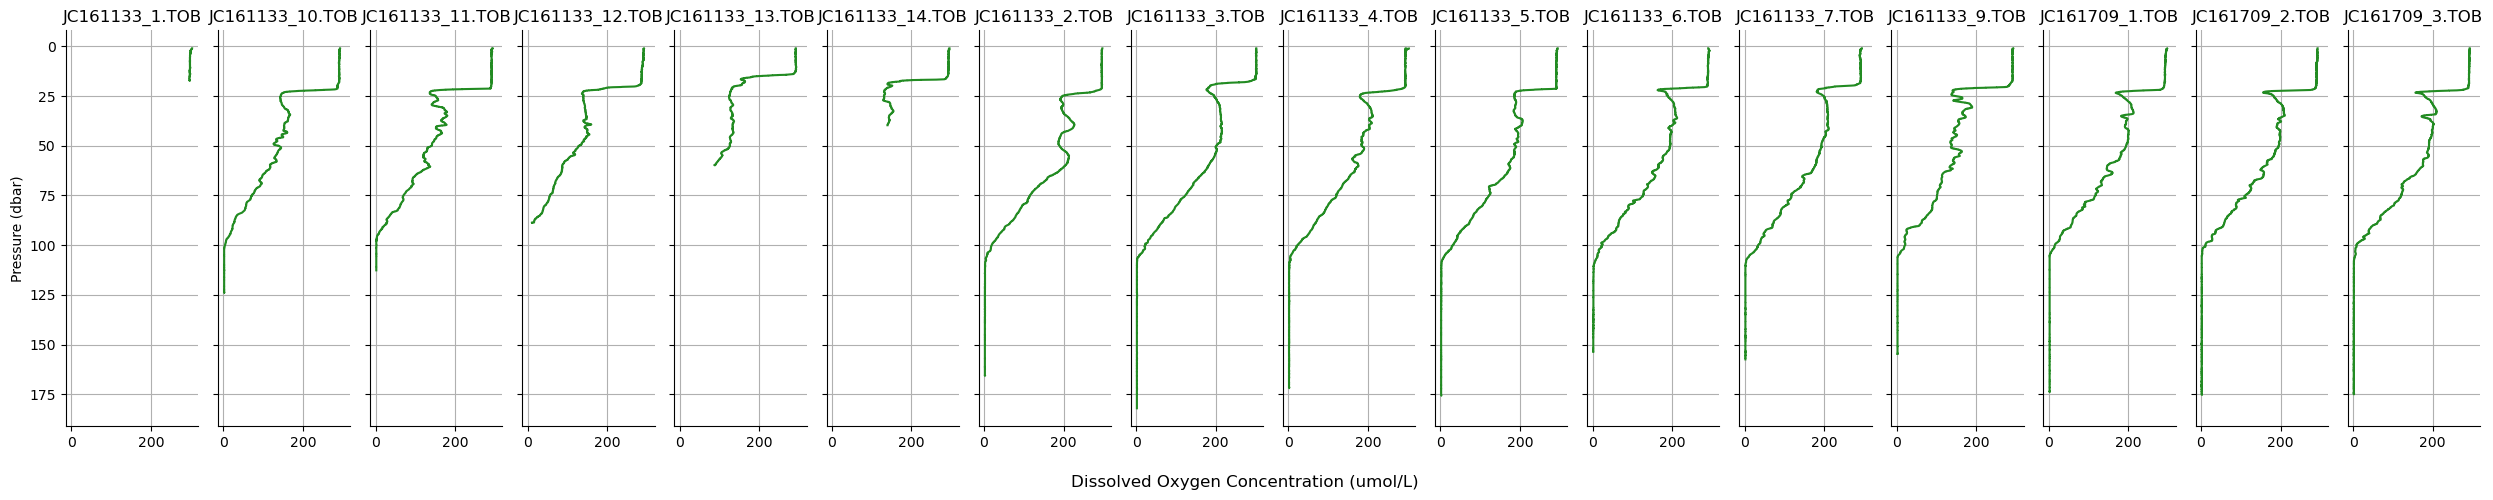

In [14]:
plot_profiles(data, 'press', 'd_oxygen_conc', 'forestgreen')

#### Repeated profiles at same location

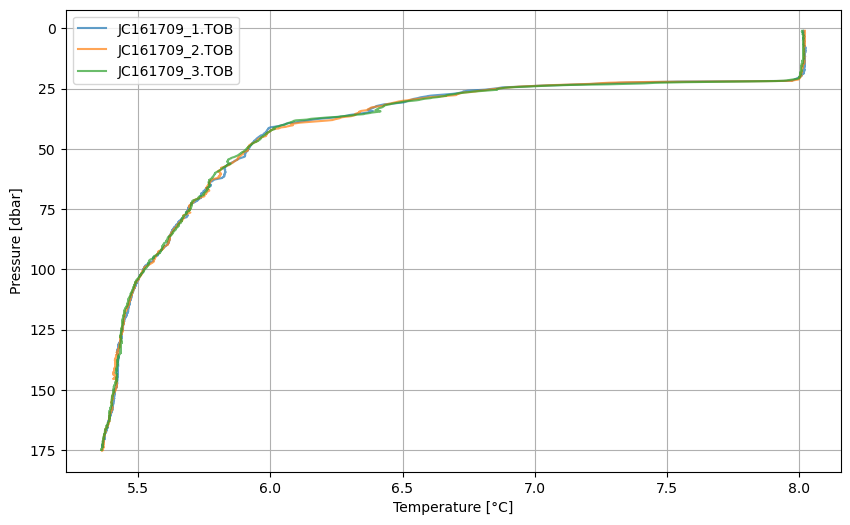

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

for _, dat in data.items():
    if 'JC161709' in dat['name']: # or dat['loc'] in ['P06', 'P07']:
        ax.plot(dat['temp'], dat['press'], alpha=0.7,label=dat['name'])

ax.set_xlabel('Temperature [°C]')
ax.set_ylabel('Pressure [dbar]')

ax.invert_yaxis()
ax.legend()
ax.grid()
plt.show()

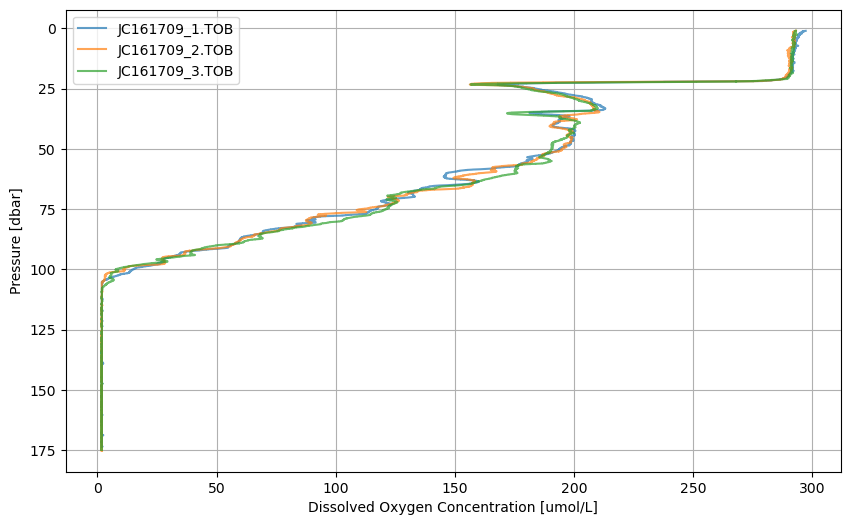

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
for _, dat in data.items():
    if 'JC161709' in dat['name']: # or dat['loc'] in ['P06', 'P07']:
        ax.plot(dat['d_oxygen_conc'], dat['press'], alpha=0.7, label=dat['name'])

ax.set_xlabel('Dissolved Oxygen Concentration [umol/L]')
ax.set_ylabel('Pressure [dbar]')

ax.invert_yaxis()
ax.legend()
ax.grid()
plt.show()

In [24]:
10 / (1000 / 32)

0.32

#### Workspace

In [47]:
def locate_files(root, data_dir, ext):
    dpath = os.path.join(root, data_dir)
    md_files = glob(os.path.join(dpath, '*.meta'))

    profiles = []
    for mdf in md_files:
        fpath, _ = os.path.splitext(mdf)
        profiles.append(f'{fpath}.{ext}')

    return md_files, profiles

def parse_sea_and_sun_L0(fpath):
    """
    Parse raw (L0) data from Sea & Sun CTD.

    Returns
    -------
    data : pd.DataFrame
        Data from Sea & Sun CTD.
    """
    COLS_DROP_SEASUN = ['CAP25', 'DO_ml', 'pH', 'Redox', 'Vbatt', 'IntD', 'IntT']
    COLS_MAP_SEASUN = {
        'Press': 'press',
        'Temp': 'temp',
        'Cond': 'cond',
        'Turb': 'turb',
        'sat': 'd_oxygen_sat',
        'DO_mg': 'd_oxygen_conc',
        'pH_Tc': 'pH',
    }

    with open(fpath, encoding='latin1', errors='ignore') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if 'Lines' in line:
            break
    else:
        raise ValueError("Start of data not found within file.")
    
    cols = lines[i+2].replace(";", "").split()[1:]
    #units = lines[i+3].replace(";", "").replace("[", "").replace("]", "").split()

    data = pd.read_csv(fpath, sep=r'\s+', header=None, skiprows=i+5, names=cols, engine='python', encoding='cp1252')
    data['time'] = pd.to_datetime(data['IntD'] + " " + data['IntT'], format='%d.%m.%Y %H:%M:%S.%f')
    data['time'] = data['time'].dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')

    data = data.drop(COLS_DROP_SEASUN, axis=1)
    data = data.rename(columns=COLS_MAP_SEASUN)

    return data

In [48]:
md_files, profiles = locate_files(root, dpath, 'TOB')

In [65]:
# focus on repeated profiles at same position
df = []
idx = 0
for md_file, profile in tqdm(zip(md_files, profiles)):
    with open(md_file, 'r') as f:
        md = json.load(f)

    if md['profile']['Profile name'] == 'PC':
        data = parse_sea_and_sun_L0(profile)
        
        # select downcast
        bottom_idx = np.argmax(data['press'])
        data = data[:bottom_idx]

        # remove air
        data = data[data['press'] > 1]

        # convert DO units
        data['d_oxygen_conc'] = data['d_oxygen_conc'] * (1000/32)

        data['idx'] = idx
        idx += 1

        df.append(data)

df = pd.concat(df, ignore_index=True)


0it [00:00, ?it/s]

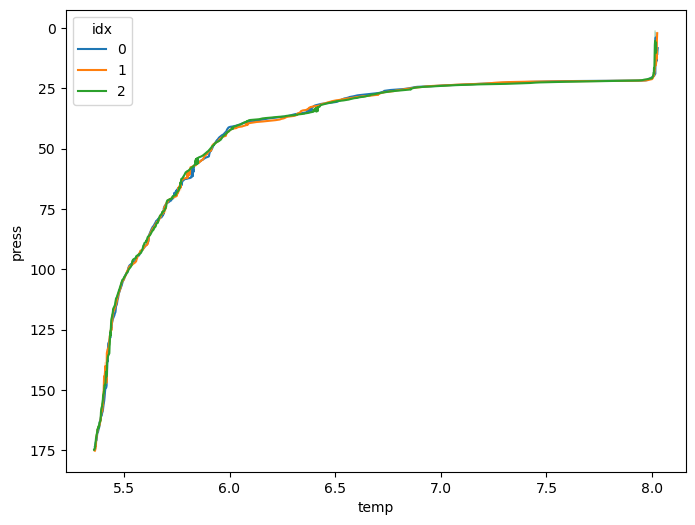

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(df, x='temp', y='press', hue='idx', palette='tab10', ax=ax)

ax.invert_yaxis()

plt.show()

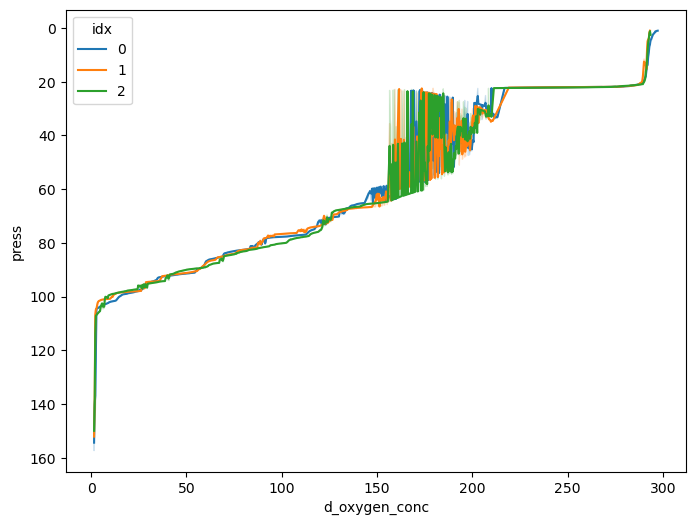

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(df, x='d_oxygen_conc', y='press', hue='idx', palette='tab10', ax=ax)

ax.invert_yaxis()

plt.show()

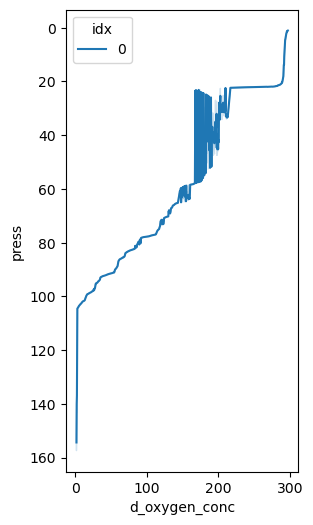

In [71]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.lineplot(df.query('idx == 0'), x='d_oxygen_conc', y='press', hue='idx', palette='tab10', ax=ax)

ax.invert_yaxis()

plt.show()